In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_rna/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_rna/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_rna/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_rna/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 42492 × 10000
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13431
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 10000
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(5616, 13431)
(5616, 10000)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(403, 13431)
(403, 10000)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([37087, 1])

In [33]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([7865, 1])

In [34]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [37]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'No_norm_model_RNA_DNA'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.13238142  Validation_loss:  0.16690303  Test_loss:  0.1333788


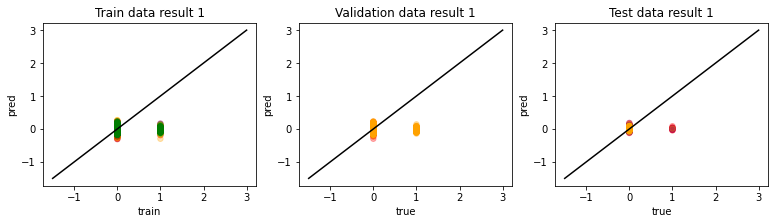

Epoch  100 Train_loss:  0.12814704  Validation_loss:  0.16288182  Test_loss:  0.13262787
Epoch  200 Train_loss:  0.1270344  Validation_loss:  0.16191338  Test_loss:  0.13203855
Epoch  300 Train_loss:  0.12621596  Validation_loss:  0.16122589  Test_loss:  0.13165474
Epoch  400 Train_loss:  0.12554102  Validation_loss:  0.16066685  Test_loss:  0.13137276
Epoch  500 Train_loss:  0.12495448  Validation_loss:  0.16018832  Test_loss:  0.13114491
Epoch  600 Train_loss:  0.124421984  Validation_loss:  0.15975626  Test_loss:  0.13094942
Epoch  700 Train_loss:  0.123928  Validation_loss:  0.15935992  Test_loss:  0.13077788
Epoch  800 Train_loss:  0.123466805  Validation_loss:  0.15899704  Test_loss:  0.13062403
Epoch  900 Train_loss:  0.123037204  Validation_loss:  0.15865888  Test_loss:  0.13048418
Epoch  1000 Train_loss:  0.12263279  Validation_loss:  0.1583402  Test_loss:  0.13035703


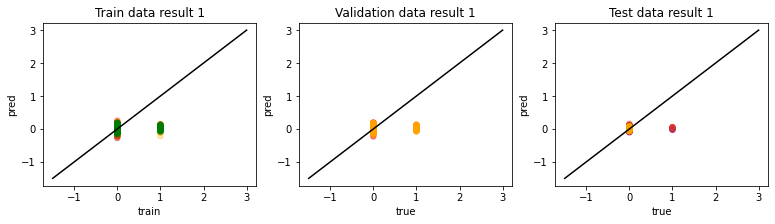

Epoch  1100 Train_loss:  0.12224899  Validation_loss:  0.15803732  Test_loss:  0.13024032
Epoch  1200 Train_loss:  0.12188457  Validation_loss:  0.15775189  Test_loss:  0.13013126
Epoch  1300 Train_loss:  0.12153625  Validation_loss:  0.15747747  Test_loss:  0.13002743
Epoch  1400 Train_loss:  0.121203884  Validation_loss:  0.15721424  Test_loss:  0.12992765
Epoch  1500 Train_loss:  0.12088803  Validation_loss:  0.1569664  Test_loss:  0.12983572
Epoch  1600 Train_loss:  0.12058708  Validation_loss:  0.1567244  Test_loss:  0.12974592
Epoch  1700 Train_loss:  0.120300494  Validation_loss:  0.15649724  Test_loss:  0.12966287
Epoch  1800 Train_loss:  0.120023936  Validation_loss:  0.1562758  Test_loss:  0.12958483
Epoch  1900 Train_loss:  0.11975913  Validation_loss:  0.15606177  Test_loss:  0.1295104
Epoch  2000 Train_loss:  0.11950466  Validation_loss:  0.15585539  Test_loss:  0.12944187


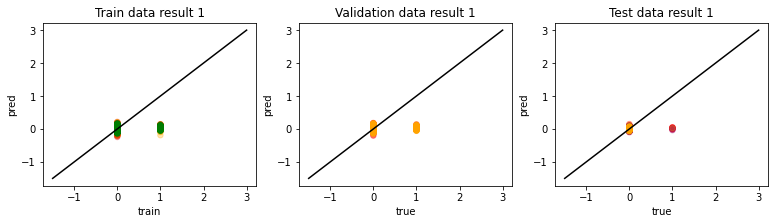

Epoch  2100 Train_loss:  0.11925891  Validation_loss:  0.15565728  Test_loss:  0.12937912
Epoch  2200 Train_loss:  0.119022116  Validation_loss:  0.15546358  Test_loss:  0.12931624
Epoch  2300 Train_loss:  0.11879529  Validation_loss:  0.15527909  Test_loss:  0.12925714
Epoch  2400 Train_loss:  0.11857526  Validation_loss:  0.15510055  Test_loss:  0.1291999
Epoch  2500 Train_loss:  0.1183634  Validation_loss:  0.15492739  Test_loss:  0.12914416
Epoch  2600 Train_loss:  0.11815966  Validation_loss:  0.15475942  Test_loss:  0.12909056
Epoch  2700 Train_loss:  0.11796377  Validation_loss:  0.15459661  Test_loss:  0.12903894
Epoch  2800 Train_loss:  0.11777434  Validation_loss:  0.15443765  Test_loss:  0.12898725
Epoch  2900 Train_loss:  0.117591575  Validation_loss:  0.1542843  Test_loss:  0.12893796
Epoch  3000 Train_loss:  0.11741419  Validation_loss:  0.154135  Test_loss:  0.12889057


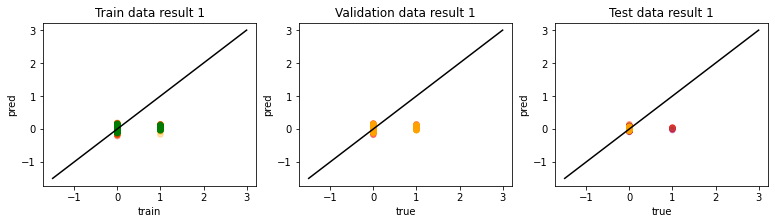

Epoch  3100 Train_loss:  0.11724374  Validation_loss:  0.15399045  Test_loss:  0.12884228
Epoch  3200 Train_loss:  0.11707778  Validation_loss:  0.15385127  Test_loss:  0.12879783
Epoch  3300 Train_loss:  0.116916016  Validation_loss:  0.15371461  Test_loss:  0.12875235
Epoch  3400 Train_loss:  0.11675971  Validation_loss:  0.15358381  Test_loss:  0.12871058
Epoch  3500 Train_loss:  0.11660741  Validation_loss:  0.15345383  Test_loss:  0.12866865
Epoch  3600 Train_loss:  0.11645965  Validation_loss:  0.15332831  Test_loss:  0.12862863
Epoch  3700 Train_loss:  0.116316095  Validation_loss:  0.15320799  Test_loss:  0.1285915
Epoch  3800 Train_loss:  0.11617716  Validation_loss:  0.15308946  Test_loss:  0.12855461
Epoch  3900 Train_loss:  0.116043  Validation_loss:  0.15297398  Test_loss:  0.12851806
Epoch  4000 Train_loss:  0.115912005  Validation_loss:  0.15286313  Test_loss:  0.12848392


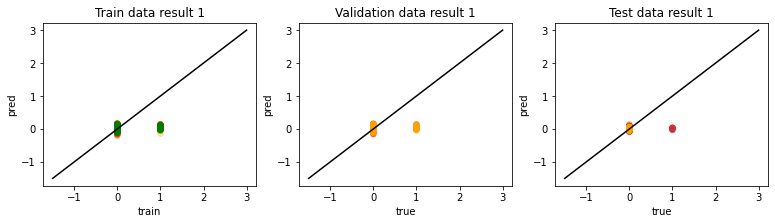

Epoch  4100 Train_loss:  0.11578509  Validation_loss:  0.15275517  Test_loss:  0.12844972
Epoch  4200 Train_loss:  0.11566141  Validation_loss:  0.15264894  Test_loss:  0.12841529
Epoch  4300 Train_loss:  0.115541175  Validation_loss:  0.15254523  Test_loss:  0.12838136
Epoch  4400 Train_loss:  0.11542418  Validation_loss:  0.15244333  Test_loss:  0.12834755
Epoch  4500 Train_loss:  0.115309685  Validation_loss:  0.15234603  Test_loss:  0.1283172
Epoch  4600 Train_loss:  0.115197524  Validation_loss:  0.15225014  Test_loss:  0.12828724
Epoch  4700 Train_loss:  0.11508823  Validation_loss:  0.15215665  Test_loss:  0.12825826
Epoch  4800 Train_loss:  0.1149819  Validation_loss:  0.15206511  Test_loss:  0.12822953
Epoch  4900 Train_loss:  0.11487775  Validation_loss:  0.15197533  Test_loss:  0.12820043
Epoch  5000 Train_loss:  0.11477597  Validation_loss:  0.15188728  Test_loss:  0.12817073


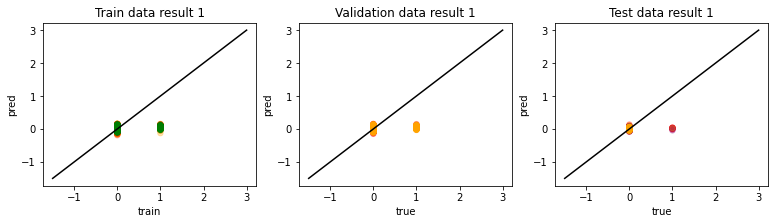

Epoch  5100 Train_loss:  0.11467669  Validation_loss:  0.15180054  Test_loss:  0.12814294
Epoch  5200 Train_loss:  0.11457929  Validation_loss:  0.15171684  Test_loss:  0.12811679
Epoch  5300 Train_loss:  0.11448406  Validation_loss:  0.15163465  Test_loss:  0.12809105
Epoch  5400 Train_loss:  0.114390835  Validation_loss:  0.1515532  Test_loss:  0.12806495
Epoch  5500 Train_loss:  0.11429951  Validation_loss:  0.1514739  Test_loss:  0.12803936
Epoch  5600 Train_loss:  0.114210136  Validation_loss:  0.15139556  Test_loss:  0.12801428
Epoch  5700 Train_loss:  0.11412297  Validation_loss:  0.15131909  Test_loss:  0.12798959
Epoch  5800 Train_loss:  0.114037275  Validation_loss:  0.15124449  Test_loss:  0.12796669
Epoch  5900 Train_loss:  0.113953255  Validation_loss:  0.15117018  Test_loss:  0.12794322
Epoch  6000 Train_loss:  0.11387079  Validation_loss:  0.15109701  Test_loss:  0.12791944


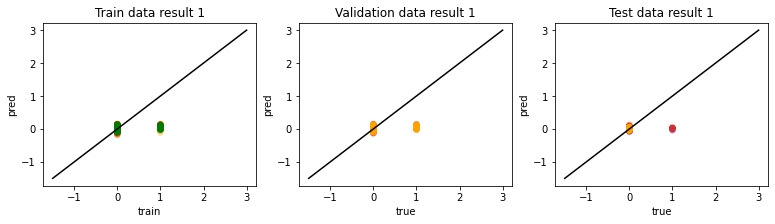

Epoch  6100 Train_loss:  0.113789916  Validation_loss:  0.15102471  Test_loss:  0.12789556
Epoch  6200 Train_loss:  0.11371033  Validation_loss:  0.15095398  Test_loss:  0.12787396
Epoch  6300 Train_loss:  0.11363209  Validation_loss:  0.15088454  Test_loss:  0.12785235
Epoch  6400 Train_loss:  0.11355571  Validation_loss:  0.15081592  Test_loss:  0.12783036
Epoch  6500 Train_loss:  0.11348026  Validation_loss:  0.15074834  Test_loss:  0.12780981
Epoch  6600 Train_loss:  0.11340646  Validation_loss:  0.15068181  Test_loss:  0.12778918
Epoch  6700 Train_loss:  0.11333376  Validation_loss:  0.15061586  Test_loss:  0.12776977
Epoch  6800 Train_loss:  0.11326252  Validation_loss:  0.15055107  Test_loss:  0.12775111
Epoch  6900 Train_loss:  0.113192424  Validation_loss:  0.15048681  Test_loss:  0.12773249
Epoch  7000 Train_loss:  0.11312322  Validation_loss:  0.15042348  Test_loss:  0.127715


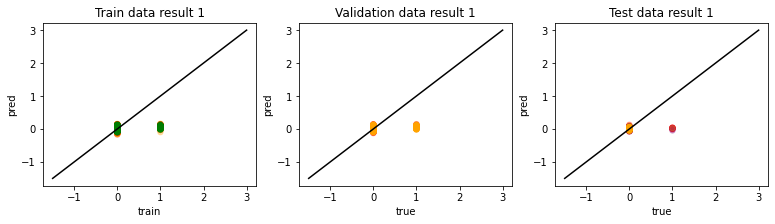

Epoch  7100 Train_loss:  0.11305527  Validation_loss:  0.15035962  Test_loss:  0.12769642
Epoch  7200 Train_loss:  0.11298815  Validation_loss:  0.15029703  Test_loss:  0.1276789
Epoch  7300 Train_loss:  0.112921804  Validation_loss:  0.1502351  Test_loss:  0.12766145
Epoch  7400 Train_loss:  0.1128567  Validation_loss:  0.15017433  Test_loss:  0.12764491
Epoch  7500 Train_loss:  0.11279217  Validation_loss:  0.1501133  Test_loss:  0.12762797
Epoch  7600 Train_loss:  0.11272874  Validation_loss:  0.15005384  Test_loss:  0.12761381
Epoch  7700 Train_loss:  0.11266624  Validation_loss:  0.14999346  Test_loss:  0.12759736
Epoch  7800 Train_loss:  0.11260435  Validation_loss:  0.14993368  Test_loss:  0.12758149
Epoch  7900 Train_loss:  0.11254376  Validation_loss:  0.14987575  Test_loss:  0.12756686
Epoch  8000 Train_loss:  0.11248351  Validation_loss:  0.14981714  Test_loss:  0.127551


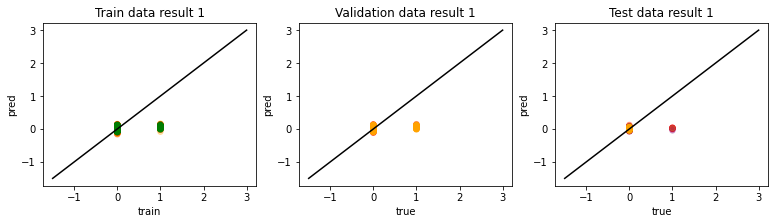

Epoch  8100 Train_loss:  0.11242412  Validation_loss:  0.14976019  Test_loss:  0.1275369
Epoch  8200 Train_loss:  0.1123653  Validation_loss:  0.1497018  Test_loss:  0.12752087
Epoch  8300 Train_loss:  0.11230716  Validation_loss:  0.1496455  Test_loss:  0.12750655
Epoch  8400 Train_loss:  0.11224959  Validation_loss:  0.14958918  Test_loss:  0.12749204
Epoch  8500 Train_loss:  0.11219263  Validation_loss:  0.14953297  Test_loss:  0.12747753
Epoch  8600 Train_loss:  0.11213647  Validation_loss:  0.14947814  Test_loss:  0.12746514
Epoch  8700 Train_loss:  0.112080865  Validation_loss:  0.14942345  Test_loss:  0.1274523
Epoch  8800 Train_loss:  0.11202563  Validation_loss:  0.14936876  Test_loss:  0.1274393
Epoch  8900 Train_loss:  0.11197096  Validation_loss:  0.1493145  Test_loss:  0.12742563
Epoch  9000 Train_loss:  0.111917056  Validation_loss:  0.14926137  Test_loss:  0.12741354


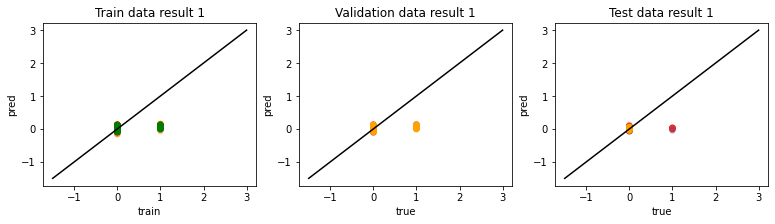

Epoch  9100 Train_loss:  0.11186344  Validation_loss:  0.14920834  Test_loss:  0.12740153
Epoch  9200 Train_loss:  0.11181061  Validation_loss:  0.14915518  Test_loss:  0.12738895
Epoch  9300 Train_loss:  0.11175806  Validation_loss:  0.14910361  Test_loss:  0.12737884
Epoch  9400 Train_loss:  0.111706235  Validation_loss:  0.14905132  Test_loss:  0.12736697
Epoch  9500 Train_loss:  0.1116547  Validation_loss:  0.14899983  Test_loss:  0.12735622
Epoch  9600 Train_loss:  0.11160374  Validation_loss:  0.14894842  Test_loss:  0.12734602
Epoch  9700 Train_loss:  0.11155323  Validation_loss:  0.14889748  Test_loss:  0.12733543
Epoch  9800 Train_loss:  0.11150329  Validation_loss:  0.14884627  Test_loss:  0.12732458
Epoch  9900 Train_loss:  0.111453705  Validation_loss:  0.14879608  Test_loss:  0.12731402
Epoch  10000 Train_loss:  0.111404605  Validation_loss:  0.14874597  Test_loss:  0.1273038


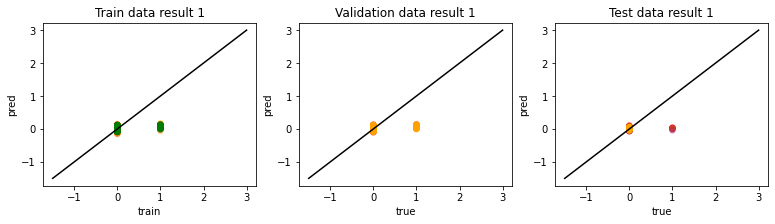

Epoch  10100 Train_loss:  0.11135591  Validation_loss:  0.14869694  Test_loss:  0.1272952
Epoch  10200 Train_loss:  0.111307494  Validation_loss:  0.14864764  Test_loss:  0.12728626
Epoch  10300 Train_loss:  0.11125973  Validation_loss:  0.14859799  Test_loss:  0.1272757
Epoch  10400 Train_loss:  0.11121208  Validation_loss:  0.14854945  Test_loss:  0.1272666
Epoch  10500 Train_loss:  0.111164935  Validation_loss:  0.14850056  Test_loss:  0.12725697
Epoch  10600 Train_loss:  0.11111814  Validation_loss:  0.14845186  Test_loss:  0.12724833
Epoch  10700 Train_loss:  0.11107165  Validation_loss:  0.14840397  Test_loss:  0.12723956
Epoch  10800 Train_loss:  0.111025594  Validation_loss:  0.14835602  Test_loss:  0.12723128
Epoch  10900 Train_loss:  0.110979766  Validation_loss:  0.14830787  Test_loss:  0.12722193
Epoch  11000 Train_loss:  0.110934556  Validation_loss:  0.14826089  Test_loss:  0.12721355


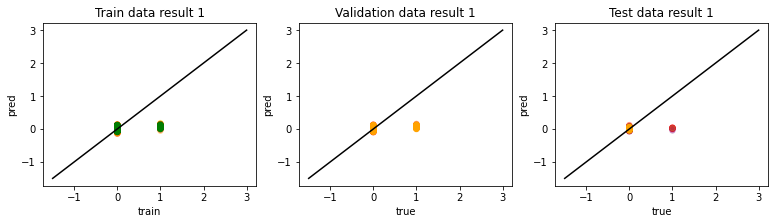

Epoch  11100 Train_loss:  0.11088933  Validation_loss:  0.14821355  Test_loss:  0.12720442
Epoch  11200 Train_loss:  0.1108446  Validation_loss:  0.1481665  Test_loss:  0.12719584
Epoch  11300 Train_loss:  0.11079994  Validation_loss:  0.14811967  Test_loss:  0.12718835
Epoch  11400 Train_loss:  0.11075577  Validation_loss:  0.14807296  Test_loss:  0.12718004
Epoch  11500 Train_loss:  0.1107118  Validation_loss:  0.14802603  Test_loss:  0.12717189
Epoch  11600 Train_loss:  0.11066798  Validation_loss:  0.14797972  Test_loss:  0.1271644
Epoch  11700 Train_loss:  0.110624656  Validation_loss:  0.14793265  Test_loss:  0.12715597
Epoch  11800 Train_loss:  0.11058151  Validation_loss:  0.14788708  Test_loss:  0.12714943
Epoch  11900 Train_loss:  0.11053853  Validation_loss:  0.14784124  Test_loss:  0.12714218
Epoch  12000 Train_loss:  0.110495746  Validation_loss:  0.14779453  Test_loss:  0.12713368


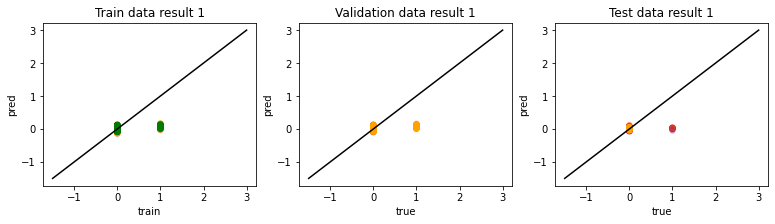

Epoch  12100 Train_loss:  0.11045333  Validation_loss:  0.14774932  Test_loss:  0.12712748
Epoch  12200 Train_loss:  0.11041114  Validation_loss:  0.14770342  Test_loss:  0.12712023
Epoch  12300 Train_loss:  0.11036924  Validation_loss:  0.14765863  Test_loss:  0.1271143
Epoch  12400 Train_loss:  0.11032749  Validation_loss:  0.1476132  Test_loss:  0.12710762
Epoch  12500 Train_loss:  0.11028578  Validation_loss:  0.14756757  Test_loss:  0.12710111
Epoch  12600 Train_loss:  0.110244624  Validation_loss:  0.14752269  Test_loss:  0.12709516
Epoch  12700 Train_loss:  0.11020369  Validation_loss:  0.14747761  Test_loss:  0.12708846
Epoch  12800 Train_loss:  0.11016299  Validation_loss:  0.14743313  Test_loss:  0.12708221
Epoch  12900 Train_loss:  0.11012235  Validation_loss:  0.14738849  Test_loss:  0.12707642
Epoch  13000 Train_loss:  0.1100821  Validation_loss:  0.14734432  Test_loss:  0.12707065


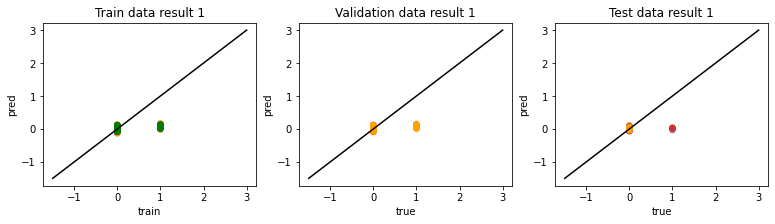

Epoch  13100 Train_loss:  0.1100419  Validation_loss:  0.14729998  Test_loss:  0.12706472
Epoch  13200 Train_loss:  0.11000193  Validation_loss:  0.14725602  Test_loss:  0.12705976
Epoch  13300 Train_loss:  0.10996209  Validation_loss:  0.14721152  Test_loss:  0.12705322
Epoch  13400 Train_loss:  0.109922506  Validation_loss:  0.14716786  Test_loss:  0.12704812
Epoch  13500 Train_loss:  0.109883085  Validation_loss:  0.14712419  Test_loss:  0.1270423
Epoch  13600 Train_loss:  0.10984383  Validation_loss:  0.14708078  Test_loss:  0.12703724
Epoch  13700 Train_loss:  0.10980483  Validation_loss:  0.14703742  Test_loss:  0.12703167
Epoch  13800 Train_loss:  0.10976575  Validation_loss:  0.14699388  Test_loss:  0.12702656
Epoch  13900 Train_loss:  0.10972707  Validation_loss:  0.14695036  Test_loss:  0.12702134
Epoch  14000 Train_loss:  0.109688535  Validation_loss:  0.14690733  Test_loss:  0.12701656


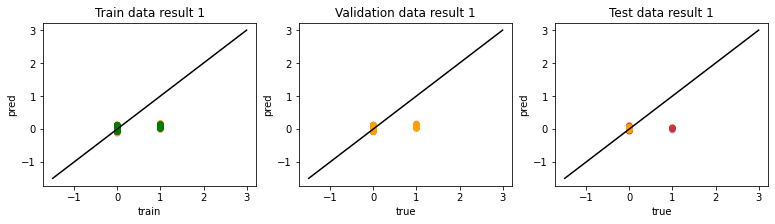

Epoch  14100 Train_loss:  0.10965008  Validation_loss:  0.1468639  Test_loss:  0.12701073
Epoch  14200 Train_loss:  0.10961188  Validation_loss:  0.14682104  Test_loss:  0.12700547
Epoch  14300 Train_loss:  0.109573945  Validation_loss:  0.14677842  Test_loss:  0.12700078
Epoch  14400 Train_loss:  0.10953589  Validation_loss:  0.14673592  Test_loss:  0.12699625
Epoch  14500 Train_loss:  0.10949804  Validation_loss:  0.14669372  Test_loss:  0.1269926
Epoch  14600 Train_loss:  0.10946045  Validation_loss:  0.14665098  Test_loss:  0.12698734
Epoch  14700 Train_loss:  0.109422944  Validation_loss:  0.14660884  Test_loss:  0.12698375
Epoch  14800 Train_loss:  0.10938566  Validation_loss:  0.14656639  Test_loss:  0.12697908
Epoch  14900 Train_loss:  0.10934835  Validation_loss:  0.14652438  Test_loss:  0.12697512
Epoch  15000 Train_loss:  0.109311335  Validation_loss:  0.1464819  Test_loss:  0.12697025


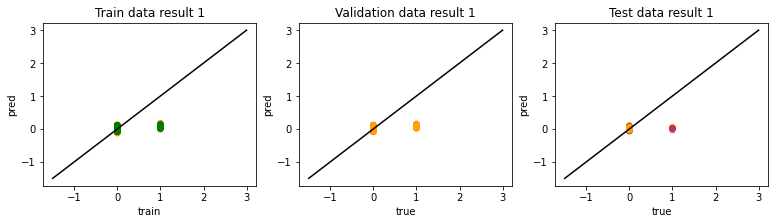

Epoch  15100 Train_loss:  0.10927419  Validation_loss:  0.14643951  Test_loss:  0.12696537
Epoch  15200 Train_loss:  0.10923738  Validation_loss:  0.14639817  Test_loss:  0.12696236
Epoch  15300 Train_loss:  0.10920081  Validation_loss:  0.14635679  Test_loss:  0.12695953
Epoch  15400 Train_loss:  0.10916419  Validation_loss:  0.1463147  Test_loss:  0.12695515
Epoch  15500 Train_loss:  0.10912779  Validation_loss:  0.14627251  Test_loss:  0.12695009
Epoch  15600 Train_loss:  0.10909152  Validation_loss:  0.1462314  Test_loss:  0.12694737
Epoch  15700 Train_loss:  0.109055355  Validation_loss:  0.14618973  Test_loss:  0.12694296
Epoch  15800 Train_loss:  0.10901923  Validation_loss:  0.14614853  Test_loss:  0.1269403
Epoch  15900 Train_loss:  0.10898335  Validation_loss:  0.14610662  Test_loss:  0.12693654
Epoch  16000 Train_loss:  0.10894766  Validation_loss:  0.14606547  Test_loss:  0.12693311


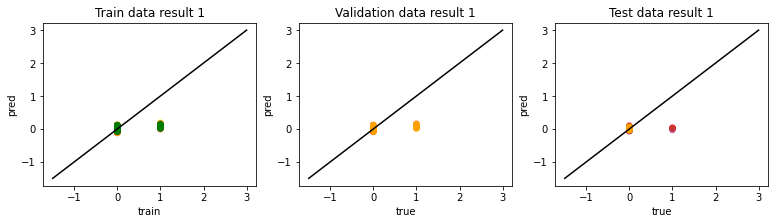

Epoch  16100 Train_loss:  0.10891193  Validation_loss:  0.14602417  Test_loss:  0.1269299
Epoch  16200 Train_loss:  0.108876504  Validation_loss:  0.14598326  Test_loss:  0.12692688
Epoch  16300 Train_loss:  0.108841024  Validation_loss:  0.14594212  Test_loss:  0.12692328
Epoch  16400 Train_loss:  0.10880577  Validation_loss:  0.14590093  Test_loss:  0.12691993
Epoch  16500 Train_loss:  0.108770415  Validation_loss:  0.14585966  Test_loss:  0.12691702
Epoch  16600 Train_loss:  0.108735465  Validation_loss:  0.14581925  Test_loss:  0.12691489
Epoch  16700 Train_loss:  0.1087003  Validation_loss:  0.14577824  Test_loss:  0.12691128
Epoch  16800 Train_loss:  0.10866541  Validation_loss:  0.14573736  Test_loss:  0.12690853
Epoch  16900 Train_loss:  0.108630605  Validation_loss:  0.14569673  Test_loss:  0.12690568
Epoch  17000 Train_loss:  0.10859581  Validation_loss:  0.14565574  Test_loss:  0.12690252


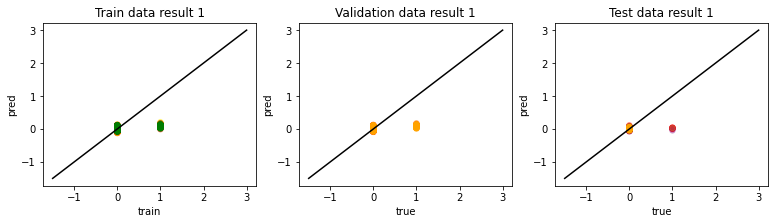

Epoch  17100 Train_loss:  0.10856118  Validation_loss:  0.145615  Test_loss:  0.12689954
Epoch  17200 Train_loss:  0.10852665  Validation_loss:  0.14557451  Test_loss:  0.12689653
Epoch  17300 Train_loss:  0.108492255  Validation_loss:  0.14553456  Test_loss:  0.12689511
Epoch  17400 Train_loss:  0.108457856  Validation_loss:  0.14549413  Test_loss:  0.12689202
Epoch  17500 Train_loss:  0.108423725  Validation_loss:  0.14545426  Test_loss:  0.1268902
Epoch  17600 Train_loss:  0.10838959  Validation_loss:  0.1454139  Test_loss:  0.12688659
Epoch  17700 Train_loss:  0.108355455  Validation_loss:  0.14537397  Test_loss:  0.12688419
Epoch  17800 Train_loss:  0.10832144  Validation_loss:  0.14533398  Test_loss:  0.12688154
Epoch  17900 Train_loss:  0.108287625  Validation_loss:  0.14529346  Test_loss:  0.12687767
Epoch  18000 Train_loss:  0.108253874  Validation_loss:  0.14525405  Test_loss:  0.12687606


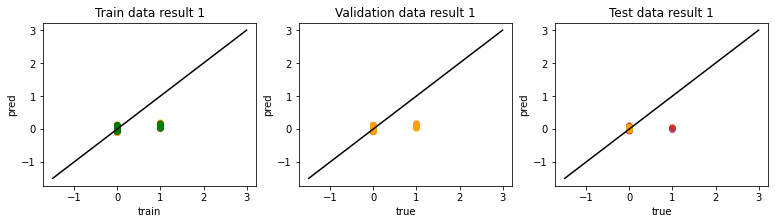

Epoch  18100 Train_loss:  0.1082201  Validation_loss:  0.14521398  Test_loss:  0.1268735
Epoch  18200 Train_loss:  0.10818642  Validation_loss:  0.1451744  Test_loss:  0.12687092
Epoch  18300 Train_loss:  0.108152874  Validation_loss:  0.14513478  Test_loss:  0.12686914
Epoch  18400 Train_loss:  0.10811937  Validation_loss:  0.1450948  Test_loss:  0.12686647
Epoch  18500 Train_loss:  0.1080859  Validation_loss:  0.1450554  Test_loss:  0.1268642
Epoch  18600 Train_loss:  0.10805255  Validation_loss:  0.14501534  Test_loss:  0.12686183
Epoch  18700 Train_loss:  0.108019195  Validation_loss:  0.14497581  Test_loss:  0.12685972
Epoch  18800 Train_loss:  0.10798592  Validation_loss:  0.14493625  Test_loss:  0.12685752
Epoch  18900 Train_loss:  0.107952684  Validation_loss:  0.14489661  Test_loss:  0.12685531
Epoch  19000 Train_loss:  0.107919596  Validation_loss:  0.1448572  Test_loss:  0.12685354


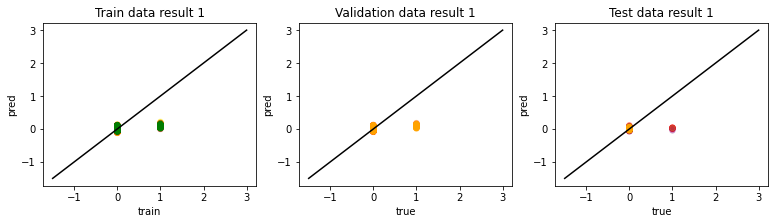

Epoch  19100 Train_loss:  0.107886456  Validation_loss:  0.144818  Test_loss:  0.12685181
Epoch  19200 Train_loss:  0.107853614  Validation_loss:  0.1447786  Test_loss:  0.12684934
Epoch  19300 Train_loss:  0.107820645  Validation_loss:  0.14473945  Test_loss:  0.12684779
Epoch  19400 Train_loss:  0.10778771  Validation_loss:  0.14469995  Test_loss:  0.12684546
Epoch  19500 Train_loss:  0.1077549  Validation_loss:  0.1446602  Test_loss:  0.12684274
Epoch  19600 Train_loss:  0.10772212  Validation_loss:  0.14462103  Test_loss:  0.12684125
Epoch  19700 Train_loss:  0.10768931  Validation_loss:  0.14458193  Test_loss:  0.12683967
Epoch  19800 Train_loss:  0.107656784  Validation_loss:  0.14454265  Test_loss:  0.12683766
Epoch  19900 Train_loss:  0.10762419  Validation_loss:  0.14450371  Test_loss:  0.12683652


In [40]:
num_epochs = 20000
learning_rate = 0.0001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.10762418  Validation_loss:  0.1445037  Test_loss:  0.12683652


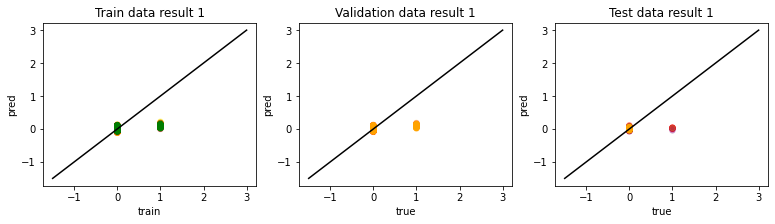

Epoch  100 Train_loss:  0.10762133  Validation_loss:  0.14450027  Test_loss:  0.12683643
Epoch  200 Train_loss:  0.10761826  Validation_loss:  0.14449652  Test_loss:  0.12683627
Epoch  300 Train_loss:  0.107615165  Validation_loss:  0.14449278  Test_loss:  0.12683618
Epoch  400 Train_loss:  0.10761208  Validation_loss:  0.14448899  Test_loss:  0.12683581
Epoch  500 Train_loss:  0.107608944  Validation_loss:  0.14448516  Test_loss:  0.12683557
Epoch  600 Train_loss:  0.10760575  Validation_loss:  0.14448139  Test_loss:  0.1268355
Epoch  700 Train_loss:  0.107602626  Validation_loss:  0.14447758  Test_loss:  0.1268351
Epoch  800 Train_loss:  0.107599474  Validation_loss:  0.14447378  Test_loss:  0.12683491
Epoch  900 Train_loss:  0.10759635  Validation_loss:  0.14446983  Test_loss:  0.1268347
Epoch  1000 Train_loss:  0.10759319  Validation_loss:  0.14446615  Test_loss:  0.12683466


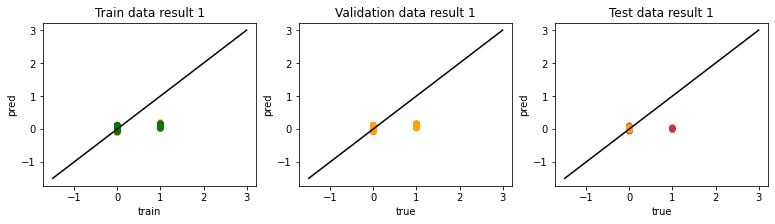

Epoch  1100 Train_loss:  0.10759008  Validation_loss:  0.14446236  Test_loss:  0.12683432
Epoch  1200 Train_loss:  0.10758702  Validation_loss:  0.14445867  Test_loss:  0.12683414
Epoch  1300 Train_loss:  0.10758383  Validation_loss:  0.14445502  Test_loss:  0.1268341
Epoch  1400 Train_loss:  0.10758068  Validation_loss:  0.14445125  Test_loss:  0.12683387
Epoch  1500 Train_loss:  0.107577614  Validation_loss:  0.14444754  Test_loss:  0.12683393
Epoch  1600 Train_loss:  0.10757456  Validation_loss:  0.14444377  Test_loss:  0.12683383
Epoch  1700 Train_loss:  0.1075714  Validation_loss:  0.14443995  Test_loss:  0.12683372
Epoch  1800 Train_loss:  0.10756833  Validation_loss:  0.14443626  Test_loss:  0.1268336
Epoch  1900 Train_loss:  0.10756524  Validation_loss:  0.14443256  Test_loss:  0.12683353
Epoch  2000 Train_loss:  0.1075621  Validation_loss:  0.14442874  Test_loss:  0.12683329


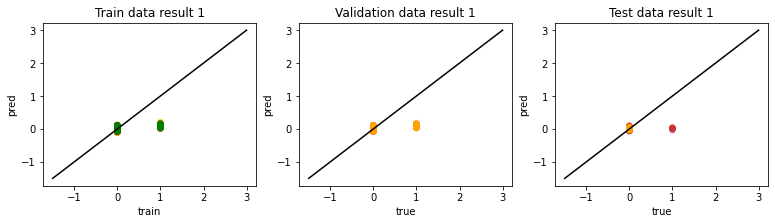

Epoch  2100 Train_loss:  0.107558936  Validation_loss:  0.14442496  Test_loss:  0.12683313
Epoch  2200 Train_loss:  0.10755576  Validation_loss:  0.14442118  Test_loss:  0.12683305
Epoch  2300 Train_loss:  0.10755269  Validation_loss:  0.14441743  Test_loss:  0.12683295
Epoch  2400 Train_loss:  0.10754963  Validation_loss:  0.14441366  Test_loss:  0.12683268
Epoch  2500 Train_loss:  0.10754651  Validation_loss:  0.14440991  Test_loss:  0.12683256
Epoch  2600 Train_loss:  0.10754341  Validation_loss:  0.14440615  Test_loss:  0.12683235
Epoch  2700 Train_loss:  0.1075403  Validation_loss:  0.14440235  Test_loss:  0.12683223
Epoch  2800 Train_loss:  0.10753718  Validation_loss:  0.14439864  Test_loss:  0.1268322
Epoch  2900 Train_loss:  0.10753402  Validation_loss:  0.14439496  Test_loss:  0.12683222
Epoch  3000 Train_loss:  0.10753098  Validation_loss:  0.14439127  Test_loss:  0.12683205


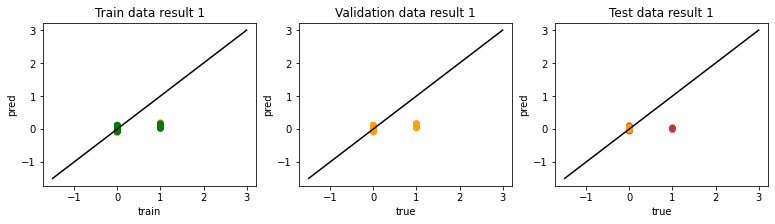

Epoch  3100 Train_loss:  0.10752784  Validation_loss:  0.14438751  Test_loss:  0.12683177
Epoch  3200 Train_loss:  0.10752481  Validation_loss:  0.14438371  Test_loss:  0.12683162
Epoch  3300 Train_loss:  0.107521646  Validation_loss:  0.1443799  Test_loss:  0.12683153
Epoch  3400 Train_loss:  0.10751853  Validation_loss:  0.14437616  Test_loss:  0.12683156
Epoch  3500 Train_loss:  0.10751542  Validation_loss:  0.14437239  Test_loss:  0.12683128
Epoch  3600 Train_loss:  0.107512236  Validation_loss:  0.14436862  Test_loss:  0.12683113
Epoch  3700 Train_loss:  0.10750921  Validation_loss:  0.14436494  Test_loss:  0.12683113
Epoch  3800 Train_loss:  0.10750609  Validation_loss:  0.14436123  Test_loss:  0.12683122
Epoch  3900 Train_loss:  0.107502915  Validation_loss:  0.14435738  Test_loss:  0.12683077
Epoch  4000 Train_loss:  0.10749974  Validation_loss:  0.14435364  Test_loss:  0.12683061


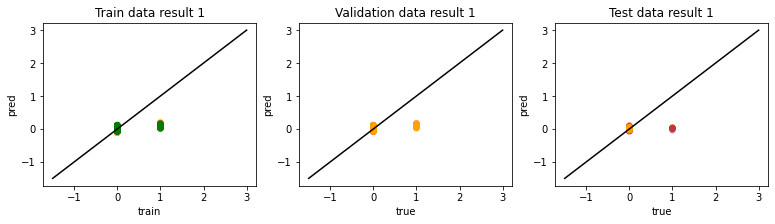

Epoch  4100 Train_loss:  0.10749673  Validation_loss:  0.14434986  Test_loss:  0.12683044
Epoch  4200 Train_loss:  0.10749366  Validation_loss:  0.14434615  Test_loss:  0.12683035
Epoch  4300 Train_loss:  0.10749055  Validation_loss:  0.14434241  Test_loss:  0.12683012
Epoch  4400 Train_loss:  0.10748744  Validation_loss:  0.14433856  Test_loss:  0.12682997
Epoch  4500 Train_loss:  0.10748433  Validation_loss:  0.14433481  Test_loss:  0.12682964
Epoch  4600 Train_loss:  0.10748123  Validation_loss:  0.14433107  Test_loss:  0.12682967
Epoch  4700 Train_loss:  0.10747816  Validation_loss:  0.14432731  Test_loss:  0.1268295
Epoch  4800 Train_loss:  0.1074751  Validation_loss:  0.14432362  Test_loss:  0.12682946
Epoch  4900 Train_loss:  0.10747198  Validation_loss:  0.1443198  Test_loss:  0.12682924
Epoch  5000 Train_loss:  0.107468896  Validation_loss:  0.14431602  Test_loss:  0.12682922


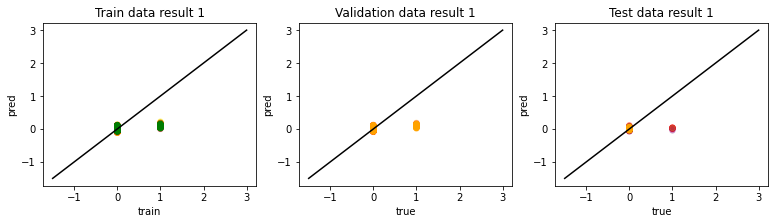

Epoch  5100 Train_loss:  0.10746575  Validation_loss:  0.14431225  Test_loss:  0.12682907
Epoch  5200 Train_loss:  0.10746265  Validation_loss:  0.14430854  Test_loss:  0.12682885
Epoch  5300 Train_loss:  0.10745959  Validation_loss:  0.14430486  Test_loss:  0.12682901
Epoch  5400 Train_loss:  0.10745646  Validation_loss:  0.14430115  Test_loss:  0.12682903
Epoch  5500 Train_loss:  0.10745338  Validation_loss:  0.14429738  Test_loss:  0.12682888
Epoch  5600 Train_loss:  0.10745034  Validation_loss:  0.1442936  Test_loss:  0.12682866
Epoch  5700 Train_loss:  0.10744723  Validation_loss:  0.14428975  Test_loss:  0.12682833
Epoch  5800 Train_loss:  0.1074441  Validation_loss:  0.14428607  Test_loss:  0.12682827
Epoch  5900 Train_loss:  0.10744108  Validation_loss:  0.14428228  Test_loss:  0.12682801
Epoch  6000 Train_loss:  0.10743795  Validation_loss:  0.14427851  Test_loss:  0.12682785


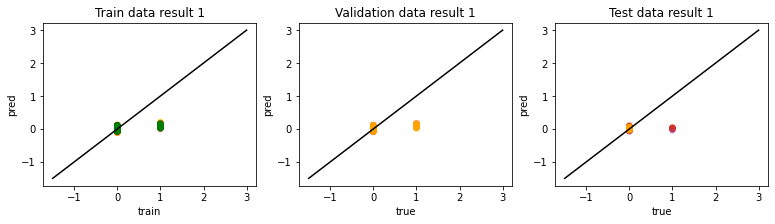

Epoch  6100 Train_loss:  0.10743485  Validation_loss:  0.14427462  Test_loss:  0.12682743
Epoch  6200 Train_loss:  0.10743177  Validation_loss:  0.14427093  Test_loss:  0.12682751
Epoch  6300 Train_loss:  0.10742866  Validation_loss:  0.14426714  Test_loss:  0.12682733
Epoch  6400 Train_loss:  0.10742554  Validation_loss:  0.14426331  Test_loss:  0.12682708
Epoch  6500 Train_loss:  0.10742245  Validation_loss:  0.14425962  Test_loss:  0.12682691
Epoch  6600 Train_loss:  0.10741937  Validation_loss:  0.14425594  Test_loss:  0.12682663
Epoch  6700 Train_loss:  0.107416265  Validation_loss:  0.14425217  Test_loss:  0.12682675
Epoch  6800 Train_loss:  0.10741315  Validation_loss:  0.14424843  Test_loss:  0.12682666
Epoch  6900 Train_loss:  0.10741011  Validation_loss:  0.14424469  Test_loss:  0.12682638
Epoch  7000 Train_loss:  0.10740703  Validation_loss:  0.144241  Test_loss:  0.1268264


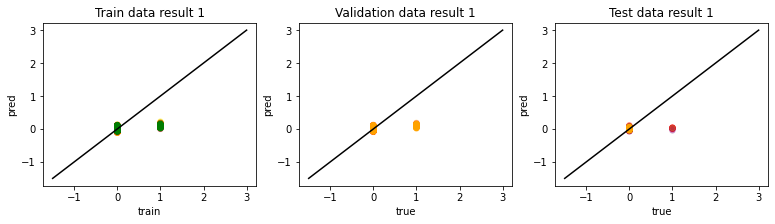

Epoch  7100 Train_loss:  0.10740391  Validation_loss:  0.14423722  Test_loss:  0.12682626
Epoch  7200 Train_loss:  0.10740084  Validation_loss:  0.14423363  Test_loss:  0.12682626
Epoch  7300 Train_loss:  0.10739778  Validation_loss:  0.14422989  Test_loss:  0.12682611
Epoch  7400 Train_loss:  0.10739472  Validation_loss:  0.14422613  Test_loss:  0.12682596
Epoch  7500 Train_loss:  0.10739164  Validation_loss:  0.14422227  Test_loss:  0.12682556
Epoch  7600 Train_loss:  0.10738856  Validation_loss:  0.14421862  Test_loss:  0.12682562
Epoch  7700 Train_loss:  0.10738548  Validation_loss:  0.14421485  Test_loss:  0.12682553
Epoch  7800 Train_loss:  0.107382275  Validation_loss:  0.14421107  Test_loss:  0.12682539
Epoch  7900 Train_loss:  0.10737914  Validation_loss:  0.14420728  Test_loss:  0.12682533
Epoch  8000 Train_loss:  0.107376084  Validation_loss:  0.14420353  Test_loss:  0.12682529


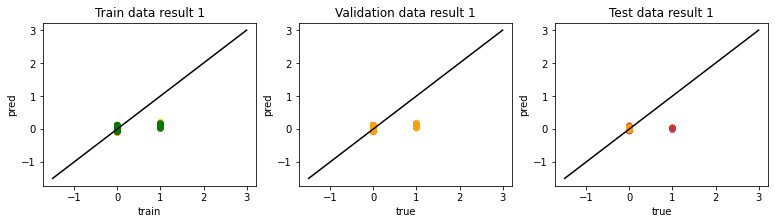

Epoch  8100 Train_loss:  0.107373044  Validation_loss:  0.14419979  Test_loss:  0.12682514
Epoch  8200 Train_loss:  0.107369974  Validation_loss:  0.14419602  Test_loss:  0.12682495
Epoch  8300 Train_loss:  0.107366964  Validation_loss:  0.14419222  Test_loss:  0.12682472
Epoch  8400 Train_loss:  0.10736383  Validation_loss:  0.14418839  Test_loss:  0.12682442
Epoch  8500 Train_loss:  0.10736077  Validation_loss:  0.14418456  Test_loss:  0.1268241
Epoch  8600 Train_loss:  0.10735767  Validation_loss:  0.14418077  Test_loss:  0.12682399
Epoch  8700 Train_loss:  0.10735458  Validation_loss:  0.14417714  Test_loss:  0.12682399
Epoch  8800 Train_loss:  0.10735146  Validation_loss:  0.1441734  Test_loss:  0.1268237
Epoch  8900 Train_loss:  0.10734843  Validation_loss:  0.14416964  Test_loss:  0.1268234
Epoch  9000 Train_loss:  0.10734533  Validation_loss:  0.1441659  Test_loss:  0.12682335


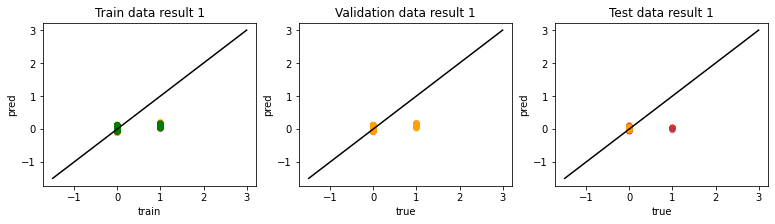

Epoch  9100 Train_loss:  0.10734217  Validation_loss:  0.1441621  Test_loss:  0.12682314
Epoch  9200 Train_loss:  0.10733911  Validation_loss:  0.1441583  Test_loss:  0.12682281
Epoch  9300 Train_loss:  0.10733595  Validation_loss:  0.14415458  Test_loss:  0.12682267
Epoch  9400 Train_loss:  0.107332826  Validation_loss:  0.14415076  Test_loss:  0.1268226
Epoch  9500 Train_loss:  0.10732977  Validation_loss:  0.14414707  Test_loss:  0.12682264
Epoch  9600 Train_loss:  0.10732666  Validation_loss:  0.1441434  Test_loss:  0.12682271
Epoch  9700 Train_loss:  0.10732362  Validation_loss:  0.14413966  Test_loss:  0.12682252
Epoch  9800 Train_loss:  0.107320555  Validation_loss:  0.14413585  Test_loss:  0.12682235
Epoch  9900 Train_loss:  0.10731745  Validation_loss:  0.14413208  Test_loss:  0.12682219
Epoch  10000 Train_loss:  0.107314356  Validation_loss:  0.14412828  Test_loss:  0.12682202


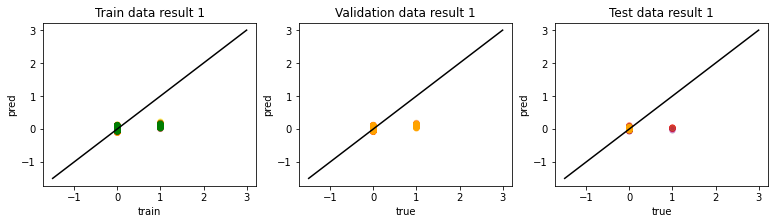

Epoch  10100 Train_loss:  0.10731124  Validation_loss:  0.14412457  Test_loss:  0.12682202
Epoch  10200 Train_loss:  0.10730819  Validation_loss:  0.14412089  Test_loss:  0.12682205
Epoch  10300 Train_loss:  0.10730517  Validation_loss:  0.14411709  Test_loss:  0.12682186
Epoch  10400 Train_loss:  0.10730201  Validation_loss:  0.14411335  Test_loss:  0.12682171
Epoch  10500 Train_loss:  0.10729895  Validation_loss:  0.1441095  Test_loss:  0.12682141
Epoch  10600 Train_loss:  0.10729582  Validation_loss:  0.14410566  Test_loss:  0.12682126
Epoch  10700 Train_loss:  0.10729282  Validation_loss:  0.14410196  Test_loss:  0.12682122
Epoch  10800 Train_loss:  0.1072897  Validation_loss:  0.14409825  Test_loss:  0.12682115
Epoch  10900 Train_loss:  0.1072867  Validation_loss:  0.14409451  Test_loss:  0.12682085
Epoch  11000 Train_loss:  0.10728357  Validation_loss:  0.14409083  Test_loss:  0.12682098


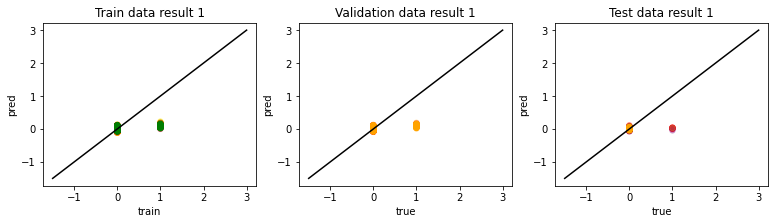

Epoch  11100 Train_loss:  0.10728057  Validation_loss:  0.14408718  Test_loss:  0.1268209
Epoch  11200 Train_loss:  0.10727752  Validation_loss:  0.14408351  Test_loss:  0.12682089
Epoch  11300 Train_loss:  0.10727442  Validation_loss:  0.14407982  Test_loss:  0.12682088
Epoch  11400 Train_loss:  0.1072713  Validation_loss:  0.14407605  Test_loss:  0.12682079
Epoch  11500 Train_loss:  0.10726829  Validation_loss:  0.14407234  Test_loss:  0.12682074
Epoch  11600 Train_loss:  0.10726515  Validation_loss:  0.14406854  Test_loss:  0.12682067
Epoch  11700 Train_loss:  0.1072621  Validation_loss:  0.14406474  Test_loss:  0.1268205
Epoch  11800 Train_loss:  0.10725908  Validation_loss:  0.1440611  Test_loss:  0.12682052
Epoch  11900 Train_loss:  0.10725594  Validation_loss:  0.14405736  Test_loss:  0.12682039
Epoch  12000 Train_loss:  0.10725298  Validation_loss:  0.14405353  Test_loss:  0.12682009


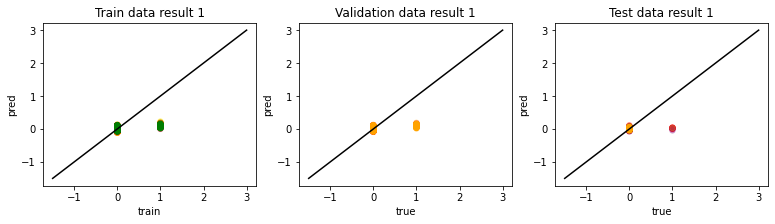

Epoch  12100 Train_loss:  0.10724993  Validation_loss:  0.14404981  Test_loss:  0.12682004
Epoch  12200 Train_loss:  0.10724686  Validation_loss:  0.14404598  Test_loss:  0.12681983
Epoch  12300 Train_loss:  0.10724381  Validation_loss:  0.14404222  Test_loss:  0.12681964
Epoch  12400 Train_loss:  0.107240744  Validation_loss:  0.14403847  Test_loss:  0.1268196
Epoch  12500 Train_loss:  0.1072376  Validation_loss:  0.14403474  Test_loss:  0.12681936
Epoch  12600 Train_loss:  0.107234485  Validation_loss:  0.14403099  Test_loss:  0.12681931
Epoch  12700 Train_loss:  0.10723142  Validation_loss:  0.14402725  Test_loss:  0.12681912
Epoch  12800 Train_loss:  0.107228346  Validation_loss:  0.14402345  Test_loss:  0.12681904
Epoch  12900 Train_loss:  0.10722523  Validation_loss:  0.14401972  Test_loss:  0.12681897
Epoch  13000 Train_loss:  0.10722217  Validation_loss:  0.1440161  Test_loss:  0.12681895


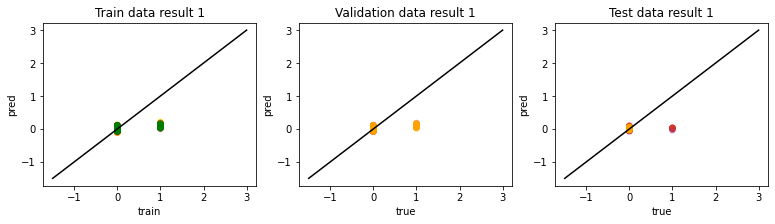

Epoch  13100 Train_loss:  0.107218996  Validation_loss:  0.14401236  Test_loss:  0.12681885
Epoch  13200 Train_loss:  0.107216045  Validation_loss:  0.14400865  Test_loss:  0.12681867
Epoch  13300 Train_loss:  0.107213  Validation_loss:  0.14400488  Test_loss:  0.12681846
Epoch  13400 Train_loss:  0.107209966  Validation_loss:  0.14400114  Test_loss:  0.12681824
Epoch  13500 Train_loss:  0.1072069  Validation_loss:  0.14399743  Test_loss:  0.12681833
Epoch  13600 Train_loss:  0.10720386  Validation_loss:  0.14399378  Test_loss:  0.12681836
Epoch  13700 Train_loss:  0.10720081  Validation_loss:  0.14399008  Test_loss:  0.1268183
Epoch  13800 Train_loss:  0.10719784  Validation_loss:  0.14398636  Test_loss:  0.12681814
Epoch  13900 Train_loss:  0.10719477  Validation_loss:  0.1439826  Test_loss:  0.1268179
Epoch  14000 Train_loss:  0.10719169  Validation_loss:  0.14397885  Test_loss:  0.12681784


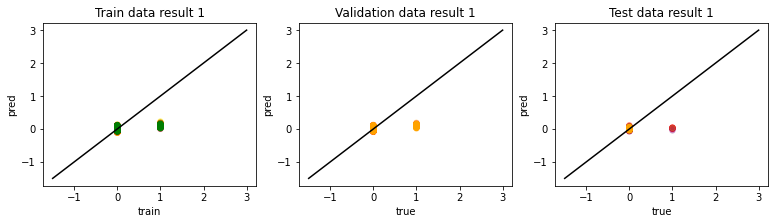

Epoch  14100 Train_loss:  0.10718862  Validation_loss:  0.14397503  Test_loss:  0.12681757
Epoch  14200 Train_loss:  0.10718549  Validation_loss:  0.14397122  Test_loss:  0.12681735
Epoch  14300 Train_loss:  0.107182436  Validation_loss:  0.14396755  Test_loss:  0.12681729
Epoch  14400 Train_loss:  0.107179314  Validation_loss:  0.14396386  Test_loss:  0.12681739
Epoch  14500 Train_loss:  0.10717631  Validation_loss:  0.14396018  Test_loss:  0.12681736
Epoch  14600 Train_loss:  0.10717326  Validation_loss:  0.14395638  Test_loss:  0.12681715
Epoch  14700 Train_loss:  0.1071702  Validation_loss:  0.14395265  Test_loss:  0.12681718
Epoch  14800 Train_loss:  0.107167095  Validation_loss:  0.14394891  Test_loss:  0.12681721
Epoch  14900 Train_loss:  0.1071641  Validation_loss:  0.14394525  Test_loss:  0.12681705
Epoch  15000 Train_loss:  0.10716098  Validation_loss:  0.1439415  Test_loss:  0.12681696


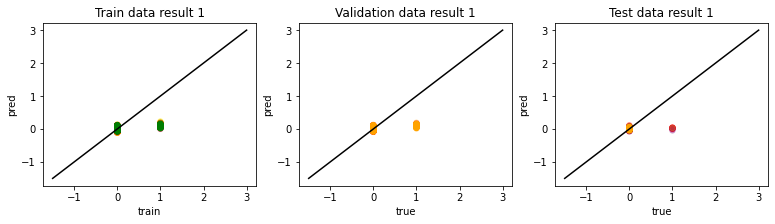

Epoch  15100 Train_loss:  0.10715795  Validation_loss:  0.1439377  Test_loss:  0.12681672
Epoch  15200 Train_loss:  0.10715487  Validation_loss:  0.14393407  Test_loss:  0.12681659
Epoch  15300 Train_loss:  0.107151866  Validation_loss:  0.14393039  Test_loss:  0.12681673
Epoch  15400 Train_loss:  0.10714872  Validation_loss:  0.14392664  Test_loss:  0.1268164
Epoch  15500 Train_loss:  0.1071457  Validation_loss:  0.1439229  Test_loss:  0.12681639
Epoch  15600 Train_loss:  0.10714259  Validation_loss:  0.14391913  Test_loss:  0.12681626
Epoch  15700 Train_loss:  0.10713948  Validation_loss:  0.1439154  Test_loss:  0.12681606
Epoch  15800 Train_loss:  0.107136466  Validation_loss:  0.1439117  Test_loss:  0.12681614
Epoch  15900 Train_loss:  0.10713342  Validation_loss:  0.14390782  Test_loss:  0.12681589
Epoch  16000 Train_loss:  0.107130274  Validation_loss:  0.1439041  Test_loss:  0.12681569


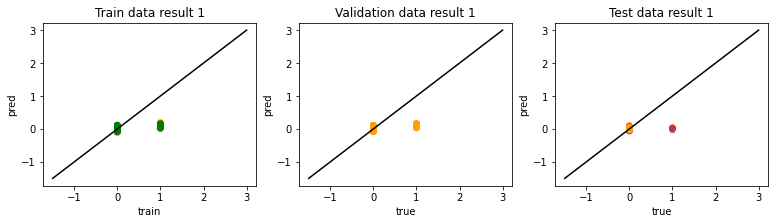

Epoch  16100 Train_loss:  0.107127234  Validation_loss:  0.14390032  Test_loss:  0.12681557
Epoch  16200 Train_loss:  0.107124284  Validation_loss:  0.1438967  Test_loss:  0.12681547
Epoch  16300 Train_loss:  0.107121274  Validation_loss:  0.14389296  Test_loss:  0.1268152
Epoch  16400 Train_loss:  0.10711819  Validation_loss:  0.14388913  Test_loss:  0.12681499
Epoch  16500 Train_loss:  0.10711516  Validation_loss:  0.1438854  Test_loss:  0.12681492
Epoch  16600 Train_loss:  0.10711213  Validation_loss:  0.14388175  Test_loss:  0.12681487
Epoch  16700 Train_loss:  0.10710908  Validation_loss:  0.1438781  Test_loss:  0.1268147
Epoch  16800 Train_loss:  0.107105955  Validation_loss:  0.14387438  Test_loss:  0.12681457
Epoch  16900 Train_loss:  0.107102886  Validation_loss:  0.14387065  Test_loss:  0.12681448
Epoch  17000 Train_loss:  0.107099876  Validation_loss:  0.14386688  Test_loss:  0.12681419


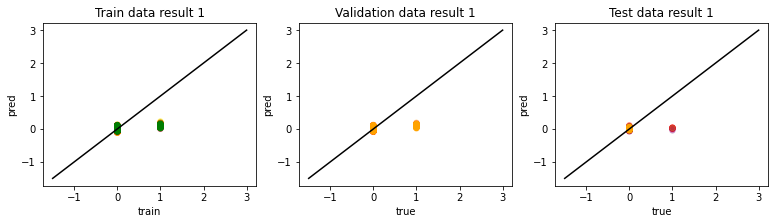

Epoch  17100 Train_loss:  0.1070969  Validation_loss:  0.14386313  Test_loss:  0.1268139
Epoch  17200 Train_loss:  0.10709387  Validation_loss:  0.1438594  Test_loss:  0.12681384
Epoch  17300 Train_loss:  0.10709078  Validation_loss:  0.14385569  Test_loss:  0.12681401
Epoch  17400 Train_loss:  0.10708767  Validation_loss:  0.14385197  Test_loss:  0.12681392
Epoch  17500 Train_loss:  0.107084565  Validation_loss:  0.14384831  Test_loss:  0.12681384
Epoch  17600 Train_loss:  0.107081555  Validation_loss:  0.14384457  Test_loss:  0.12681364
Epoch  17700 Train_loss:  0.107078455  Validation_loss:  0.14384088  Test_loss:  0.12681349
Epoch  17800 Train_loss:  0.10707543  Validation_loss:  0.14383714  Test_loss:  0.12681352
Epoch  17900 Train_loss:  0.10707244  Validation_loss:  0.1438334  Test_loss:  0.12681337
Epoch  18000 Train_loss:  0.1070694  Validation_loss:  0.14382969  Test_loss:  0.12681338


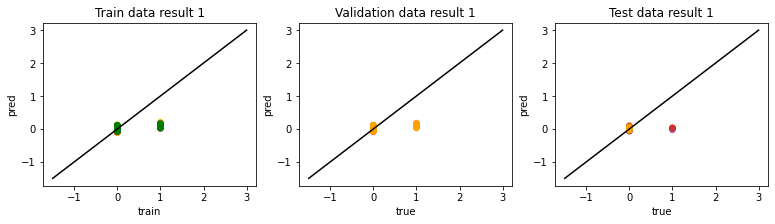

Epoch  18100 Train_loss:  0.10706638  Validation_loss:  0.14382596  Test_loss:  0.12681326
Epoch  18200 Train_loss:  0.10706335  Validation_loss:  0.14382222  Test_loss:  0.12681307
Epoch  18300 Train_loss:  0.10706025  Validation_loss:  0.14381845  Test_loss:  0.12681296
Epoch  18400 Train_loss:  0.107057214  Validation_loss:  0.14381467  Test_loss:  0.12681268
Epoch  18500 Train_loss:  0.1070542  Validation_loss:  0.14381105  Test_loss:  0.12681267
Epoch  18600 Train_loss:  0.107051164  Validation_loss:  0.14380725  Test_loss:  0.12681264
Epoch  18700 Train_loss:  0.10704808  Validation_loss:  0.14380348  Test_loss:  0.12681259
Epoch  18800 Train_loss:  0.107045  Validation_loss:  0.14379977  Test_loss:  0.12681256
Epoch  18900 Train_loss:  0.107042015  Validation_loss:  0.143796  Test_loss:  0.1268124
Epoch  19000 Train_loss:  0.10703908  Validation_loss:  0.14379247  Test_loss:  0.12681255


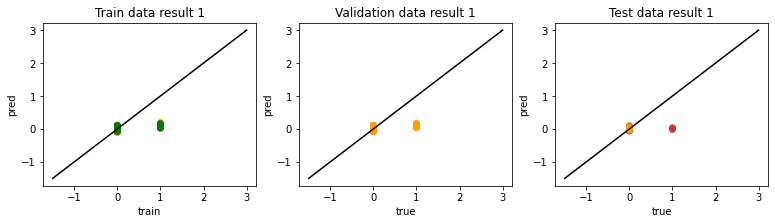

Epoch  19100 Train_loss:  0.10703596  Validation_loss:  0.14378877  Test_loss:  0.12681258
Epoch  19200 Train_loss:  0.10703292  Validation_loss:  0.1437851  Test_loss:  0.12681247
Epoch  19300 Train_loss:  0.10702989  Validation_loss:  0.14378148  Test_loss:  0.12681241
Epoch  19400 Train_loss:  0.10702688  Validation_loss:  0.14377779  Test_loss:  0.12681231
Epoch  19500 Train_loss:  0.107023805  Validation_loss:  0.14377402  Test_loss:  0.12681206
Epoch  19600 Train_loss:  0.10702077  Validation_loss:  0.14377023  Test_loss:  0.12681197
Epoch  19700 Train_loss:  0.10701778  Validation_loss:  0.14376654  Test_loss:  0.1268118
Epoch  19800 Train_loss:  0.10701472  Validation_loss:  0.14376275  Test_loss:  0.12681167
Epoch  19900 Train_loss:  0.107011676  Validation_loss:  0.14375898  Test_loss:  0.12681153


In [41]:
num_epochs = 20000
learning_rate = 0.00001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)